🎯 **TALLER 3: SERIES DE TIEMPO**

📅 **Fecha:** 2025

👤 **Equipo:** [Hector Hernan Betancourt Lopez - Marcela Fajardo Bermúdez]

* Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

# **1. Importar librerias**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import textwrap

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA

import io
import sys
import re

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# **2. Carga de datos**

In [2]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


# **3. Hold-out**

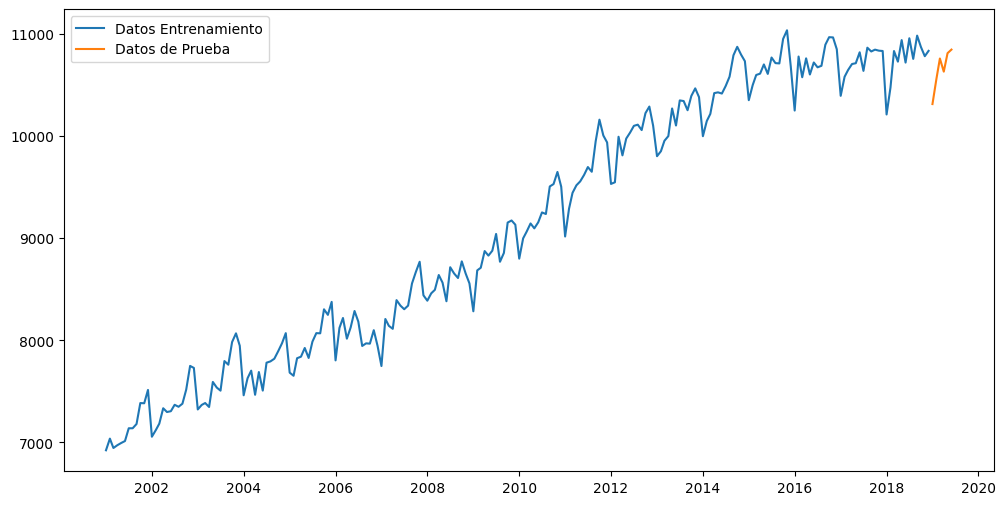

In [3]:
train_len = 216
h = 6
train_td = data[['Ocupados']][:train_len]
test_td = data[['Ocupados']][train_len:train_len+h]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

# **4. ACF Y PACF**

In [4]:
acf(train_td['Ocupados'],40)

array([1.        , 0.97842804, 0.96254063, 0.94808429, 0.93477526,
       0.92393405, 0.91046441, 0.90073659, 0.88761281, 0.87748064,
       0.86908695, 0.86549053, 0.86309578, 0.84411388, 0.82691131,
       0.81146819, 0.79951989, 0.78851595, 0.77597231, 0.76502544,
       0.75213945, 0.740503  , 0.73218145, 0.72674709, 0.72199376,
       0.70369971, 0.68410682, 0.66723623, 0.65249806, 0.64108316,
       0.62638433, 0.61429322, 0.60189809, 0.58947513, 0.5809789 ,
       0.57375215, 0.56801817, 0.54842667, 0.52869507, 0.51218875,
       0.49768442])

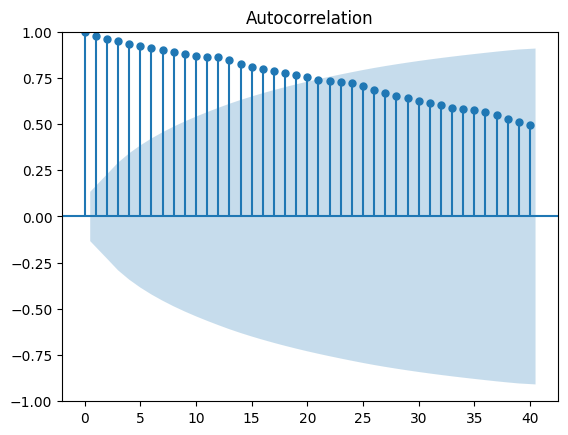

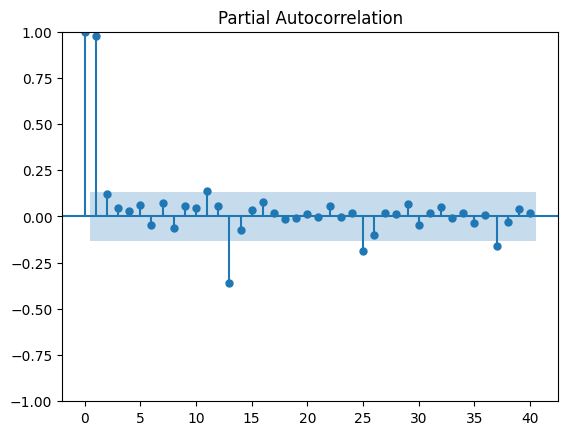

In [5]:
plot_acf(train_td['Ocupados'],lags=40);
plot_pacf(train_td['Ocupados'],lags=40);

**Nota:**

Gráfico ACF: Puede observar cómo decaen las autocorrelaciones. Un decaimiento lento en la ACF generalmente indica que la serie no es estacionaria. Esta es una característica común cuando hay una tendencia en los datos.

Gráfico PACF: El PACF muestra la correlación entre la serie y sus valores rezagados después de eliminar el efecto de los rezagos intermedios. Ayuda a identificar el orden del componente Autorregresivo (AR).

Estos gráficos son cruciales para determinar los parámetros p, d y q para un modelo ARIMA(p,d,q):

El componente 'd' (diferenciación) a menudo se sugiere por el decaimiento en la ACF. El componente 'q' (media móvil) se relaciona con picos significativos en la ACF. El componente 'p' (autorregresivo) se relaciona con picos significativos en el PACF.

# **5. Auto arima**

In [6]:
## information_criterion (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’)
model = auto_arima(train_td['Ocupados'],max_p=10, max_q=10,information_criterion = ("aic"))
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1408.709
Date:                Sat, 15 Nov 2025   AIC                           2825.418
Time:                        00:04:04   BIC                           2838.901
Sample:                    01-01-2001   HQIC                          2830.866
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.2480      2.382      4.303      0.000       5.580      14.916
ar.L1          0.4446      0.096      4.642      0.000       0.257       0.632
ma.L1         -0.8707      0.049    -17.901      0.0

In [7]:
# Capturar la salida estándar
old_stdout = sys.stdout
sys.stdout = captured_output = io.StringIO()

# Ejecutar auto_arima con trace=True para obtener todas las opciones probadas
model_capture = auto_arima(train_td['Ocupados'], max_p=10, max_q=10, information_criterion=('aic'), trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Restaurar la salida estándar
sys.stdout = old_stdout

# Obtener el contenido capturado
output_lines = captured_output.getvalue().split('\n')

# Simplified regex to extract (p,d,q) order and AIC
# This regex captures (p,d,q) in group 1 and AIC value in group 2
# It's more general for the middle part between non-seasonal order and AIC
model_pattern = re.compile(r"ARIMA\((\d,\d,\d)\).*?:\sAIC=([-+]?\d*\.?\d+|inf)")

all_model_aics = []
for line in output_lines:
    match = model_pattern.search(line)
    if match:
        order_str = match.group(1) # e.g., "1,1,1"
        aic_str = match.group(2)   # e.g., "2825.418"

        # Excluir modelos con AIC='inf'
        if aic_str != 'inf':
            aic = float(aic_str)
            # Convert order_str to a tuple (e.g., "1,1,1" -> (1,1,1))
            order_tuple = tuple(map(int, order_str.split(',')))
            all_model_aics.append({'Order': order_tuple, 'AIC': aic})

# Convertir a DataFrame
aic_df = pd.DataFrame(all_model_aics)

# Check if aic_df is empty before sorting
if aic_df.empty:
    print("No se encontraron modelos con AIC válidos en la salida de auto_arima.")
else:
    # Ordenar por AIC de forma ascendente
    aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)

    # Identificar el mejor modelo de auto_arima (capturado por model_capture)
    best_model_order = tuple(map(int, model_capture.order))

    # Filtrar el mejor modelo y obtener las siguientes 5 opciones
    other_options_aic = aic_df_sorted[aic_df_sorted['Order'].apply(lambda x: x != best_model_order)].head(10)

    print(f"El mejor modelo según auto_arima fue: ARIMA{best_model_order} con AIC={model_capture.aic():.3f}")
    print("\nTop 5 de las otras opciones probadas por auto_arima (ordenadas por AIC):")
    print(other_options_aic)

El mejor modelo según auto_arima fue: ARIMA(1, 1, 1) con AIC=2825.418

Top 5 de las otras opciones probadas por auto_arima (ordenadas por AIC):
       Order       AIC
1  (2, 1, 1)  2826.765
2  (1, 1, 2)  2826.900
3  (0, 1, 2)  2828.288
5  (0, 1, 1)  2846.080
6  (2, 1, 0)  2849.394
7  (1, 1, 0)  2855.272
8  (0, 1, 0)  2864.791
9  (0, 1, 0)  2864.805


**Nota:**

Se evidencia que, de acuerdo al AIC, se escoge el modelo SARIMAX(1, 1, 1) como mejor modelo con los datos de entrenamiento, este modelo ofrece el mejor equilibrio entre ajuste y complejidad.

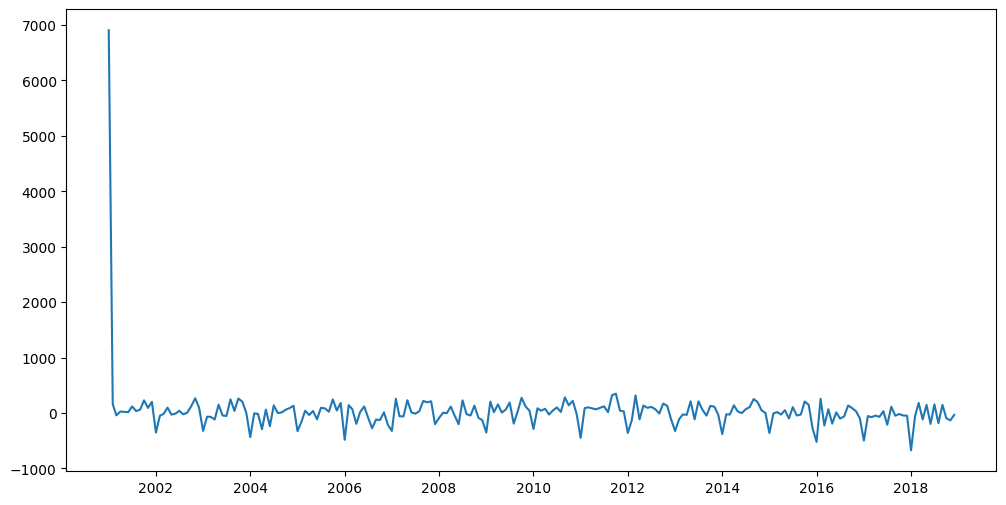

In [8]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(),label="Residuales")

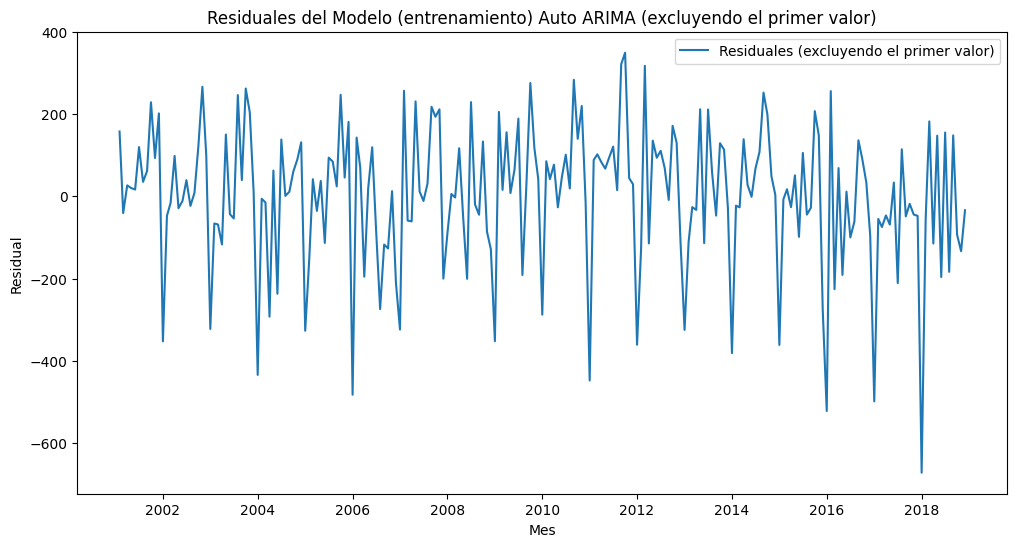

In [9]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[1:],label="Residuales (excluyendo el primer valor)")
plt.title("Residuales del Modelo (entrenamiento) Auto ARIMA (excluyendo el primer valor)")
plt.xlabel("Mes")
plt.ylabel("Residual")
plt.legend()
plt.show()

RMSE del modelo auto_arima en los datos de prueba: 346.24
MAE del modelo auto_arima en los datos de prueba: 314.94


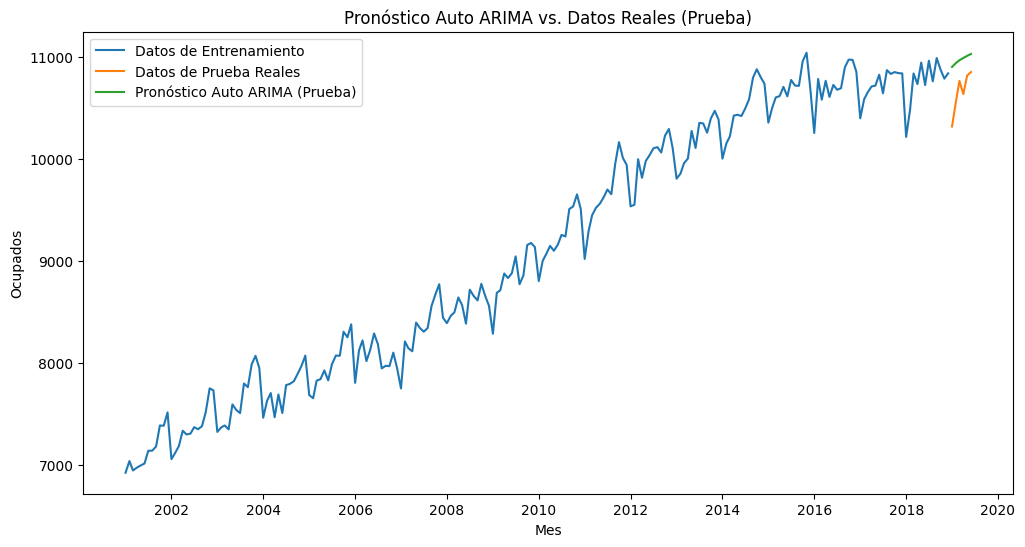

In [10]:
forecast_test = model.predict(n_periods=h)

rmse_test = sqrt(mean_squared_error(test_td['Ocupados'], forecast_test))
mae_test = mean_absolute_error(test_td['Ocupados'], forecast_test)

print(f"RMSE del modelo auto_arima en los datos de prueba: {rmse_test:.2f}")
print(f"MAE del modelo auto_arima en los datos de prueba: {mae_test:.2f}")

# Optional: Plotting the forecast against actuals
plt.figure(figsize=(12, 6))
plt.plot(train_td['Ocupados'], label='Datos de Entrenamiento')
plt.plot(test_td['Ocupados'], label='Datos de Prueba Reales')
plt.plot(forecast_test, label='Pronóstico Auto ARIMA (Prueba)')
plt.title('Pronóstico Auto ARIMA vs. Datos Reales (Prueba)')
plt.xlabel('Mes')
plt.ylabel('Ocupados')
plt.legend()
plt.show()

# **6. Comparación de modelos arima manuales con RMSE y MAE**

In [11]:
model_orders_to_evaluate_expanded = []

for p_val in range(4): # p from 0 to 3
    for d_val in range(3): # d from 0 to 2
        for q_val in range(4): # q from 0 to 3
            model_orders_to_evaluate_expanded.append((p_val, d_val, q_val))

print(f"Generated expanded ARIMA orders: {model_orders_to_evaluate_expanded}")

Generated expanded ARIMA orders: [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3)]


In [12]:
results_expanded = []

for order in model_orders_to_evaluate_expanded:
    try:
        # Instantiate an ARIMA model and fit it
        # Using suppress_warnings=True to avoid printing warnings for each model
        model = ARIMA(order=order, suppress_warnings=True)
        model.fit(train_td['Ocupados'])

        # Generate predictions for h periods (the test set length)
        forecast = model.predict(n_periods=h)

        # Calculate RMSE
        rmse = sqrt(mean_squared_error(test_td['Ocupados'], forecast))

        # Calculate MAE
        mae = mean_absolute_error(test_td['Ocupados'], forecast)

        # Append results to the list
        results_expanded.append({
            'Order': order,
            'RMSE': rmse,
            'MAE': mae
        })
    except Exception as e:
        # Catch errors during model fitting or prediction
        # Append np.nan for RMSE and MAE if an error occurs
        print(f"Error fitting model {order}: {e}")
        results_expanded.append({
            'Order': order,
            'RMSE': np.nan,
            'MAE': np.nan
        })

print("Expanded ARIMA model evaluation complete. Results:")
print(results_expanded)

Expanded ARIMA model evaluation complete. Results:
[{'Order': (0, 0, 0), 'RMSE': 1545.777943042738, 'MAE': 1534.9941527777771}, {'Order': (0, 0, 1), 'RMSE': 1458.9416429615926, 'MAE': 1398.6109983421009}, {'Order': (0, 0, 2), 'RMSE': 1337.9399533464668, 'MAE': 1204.3140354074606}, {'Order': (0, 0, 3), 'RMSE': 1294.4323398068225, 'MAE': 1226.3581203898975}, {'Order': (0, 1, 0), 'RMSE': 289.9225668273647, 'MAE': 244.7185341085245}, {'Order': (0, 1, 1), 'RMSE': 301.4125188506102, 'MAE': 258.3857959835089}, {'Order': (0, 1, 2), 'RMSE': 341.41293755832817, 'MAE': 306.2208905166505}, {'Order': (0, 1, 3), 'RMSE': 348.0894166801723, 'MAE': 315.55962508346664}, {'Order': (0, 2, 0), 'RMSE': 377.875997138638, 'MAE': 360.67874143301805}, {'Order': (0, 2, 1), 'RMSE': 271.7334454903102, 'MAE': 212.94247176086932}, {'Order': (0, 2, 2), 'RMSE': 277.8820729141964, 'MAE': 222.20035188498605}, {'Order': (0, 2, 3), 'RMSE': 305.15629052760244, 'MAE': 257.8971938654013}, {'Order': (1, 0, 0), 'RMSE': 243.325

In [13]:
results_expanded_df = pd.DataFrame(results_expanded)

# Sort by RMSE and then by MAE to get the top models
results_expanded_df_sorted = results_expanded_df.sort_values(by=['RMSE', 'MAE']).reset_index(drop=True)

print("Top 5 modelos ARIMA por RMSE y MAE en los datos de prueba (Búsqueda Ampliada):")

# Display the top 5 models with desired column names
display(results_expanded_df_sorted.head(5).rename(columns={'Order': 'Orden'}))

# Find the metrics for ARIMA(1,1,1)
arima_111_metrics = results_expanded_df_sorted[results_expanded_df_sorted['Order'].apply(lambda x: x == (1, 1, 1))]

if not arima_111_metrics.empty:
    rmse_111 = arima_111_metrics['RMSE'].values[0]
    mae_111 = arima_111_metrics['MAE'].values[0]
    display(f"\nMétricas para el modelo ARIMA(1,1,1): RMSE={rmse_111:.2f}, MAE={mae_111:.2f}")
else:
    print("\nEl modelo ARIMA(1,1,1) no se encontró en los resultados de la búsqueda ampliada.")

Top 5 modelos ARIMA por RMSE y MAE en los datos de prueba (Búsqueda Ampliada):


,Orden,RMSE,MAE
0,"(3, 2, 3)",224.745308,168.409605
1,"(2, 2, 3)",225.135958,167.983637
2,"(2, 2, 0)",228.545468,181.001273
3,"(2, 0, 2)",230.094274,172.471576
4,"(2, 0, 0)",240.555722,175.074616


'\nMétricas para el modelo ARIMA(1,1,1): RMSE=346.24, MAE=314.94'

**Nota:**

El modelo ARIMA(1,1,1) identificado por auto_arima no tiene las mejores metricas como las identificadas en los modelos ARIMA(3,2,3) y ARIMA(2,2,3) que resultaron mejores en la búsqueda manual. Esto sugiere que para los datos de prueba, dos niveles de diferenciación podrían estar capturando mejor la estacionalidad o la tendencia de la serie, lo que lleva a mejores pronósticos a futuro. auto_arima podría no haber explorado a fondo o priorizado d=2 al minimizar el AIC/BIC en la fase de entrenamiento.

Auto_arima es una excelente herramienta para encontrar rápidamente un buen punto de partida, pero si el objetivo principal es la precisión del pronóstico, una validación con RMSE/MAE en el conjunto de prueba, puede revelar modelos con un rendimiento predictivo superior.

# **7. Ajuste del modelo con all data - Pruebas con diferentes modelos**

## Mejor modelo manual

In [14]:
mejor_modelo_manual= ARIMA(order=(3,2,3))
results = mejor_modelo_manual.fit(data['Ocupados'])
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -1444.725
Date:                Sat, 15 Nov 2025   AIC                           2905.450
Time:                        00:04:15   BIC                           2932.599
Sample:                    01-01-2001   HQIC                          2916.414
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1760      0.192     -0.919      0.358      -0.552       0.199
ar.L1         -0.4649      0.202     -2.299      0.022      -0.861      -0.069
ar.L2          0.5109      0.107      4.759      0.0

**Nota:**

Se evidencian términos los cuales no aportan información significativa para explicar la serie de tiempo. Esto podría indicar que el modelo SARIMAX(3,2,3) es más complejo de lo necesario.  Se procede a explorar un modelo más parsimonioso (más simple) eliminando estos términos no significativos

In [15]:
otro_modelo_manual= ARIMA(order=(2,2,0))
results = otro_modelo_manual.fit(data['Ocupados'])
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -1510.466
Date:                Sat, 15 Nov 2025   AIC                           3028.933
Time:                        00:04:15   BIC                           3042.507
Sample:                    01-01-2001   HQIC                          3034.414
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5481     17.970      0.030      0.976     -34.673      35.769
ar.L1         -0.7502      0.061    -12.345      0.000      -0.869      -0.631
ar.L2         -0.3904      0.073     -5.325      0.0

**Nota:**

Este modelo SARIMAX(2,2,0) es modelo mucho más robusto y fiable que el SARIMAX(3,2,3) evidenciado anteriormente. Aunque su AIC es un poco más alto, sus coeficientes son significativos, sus residuos cumplen con las suposiciones de ruido blanco, normalidad y homocedasticidad. Además, este modelo (2,2,0) tuvo RMSE=228.55, MAE=181.00, lo que lo convierte en una excelente opción.

In [16]:
modelo_auto_arima= ARIMA(order=(1,1,1))
results = modelo_auto_arima.fit(data['Ocupados'])
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1451.595
Date:                Sat, 15 Nov 2025   AIC                           2911.190
Time:                        00:04:15   BIC                           2924.782
Sample:                    01-01-2001   HQIC                          2916.678
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.8551      2.485      3.965      0.000       4.984      14.726
ar.L1          0.4419      0.101      4.357      0.000       0.243       0.641
ma.L1         -0.8618      0.053    -16.414      0.0

**Nota:**

Considerando la información de los modelos expuestos, el SARIMAX(2,2,0) parece ser un modelo mejor y más robusto en general que SARIMAX(1,1,1). Aquí las razones:

Rendimiento en Datos de Prueba RMSE y MAE: El SARIMAX(2,2,0) tuvo un RMSE y un MAE significativamente más bajos 228.55 y 181.00 en los datos de prueba que el SARIMAX(1,1,1) 346.24 y 314.94. Esto indica que el SARIMAX(2,2,0) es mejor para hacer predicciones futuras.

Normalidad de los Residuos: El SARIMAX(2,2,0) mostró residuos normales Prob(JB) = 0.12, mientras que este SARIMAX(1,1,1) no lo hace Prob(JB) = 0.00.

Orden de Diferenciación: La mejor performance del SARIMAX(2,2,0) sugiere que el doble diferenciado d=2 capta mejor la tendencia o estacionalidad de la serie para la previsión fuera de la muestra, algo que el SARIMAX(1,1,1) no logra tan bien con un solo diferenciado.

Aunque este SARIMAX(1,1,1) es muy parsimonioso y tiene todos sus coeficientes significativos y residuos de ruido blanco y homocedásticos, el fallo en la normalidad de los residuos y, más importantemente, su rendimiento significativamente inferior en la predicción sobre datos de prueba (mayor RMSE y MAE), lo hacen una opción menos preferible que el SARIMAX(2,2,0)

# **8. Evaluación con todos los datos del mejor modelo**

In [17]:
modelo_final= ARIMA(order=(2,2,0))
results = modelo_final.fit(data['Ocupados'])
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(2, 2, 0)   Log Likelihood               -1510.466
Date:                Sat, 15 Nov 2025   AIC                           3028.933
Time:                        00:04:15   BIC                           3042.507
Sample:                    01-01-2001   HQIC                          3034.414
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5481     17.970      0.030      0.976     -34.673      35.769
ar.L1         -0.7502      0.061    -12.345      0.000      -0.869      -0.631
ar.L2         -0.3904      0.073     -5.325      0.0

In [18]:
h = 6 # Set the forecast horizon
res = modelo_final.resid()

my_samples = []
for _ in range(1000):

    x = np.random.choice(res, size=h, replace=True)
    my_samples.append(x)

q1=np.quantile(my_samples,0.025,axis=0)
q2=np.quantile(my_samples,0.975,axis=0)

fore = modelo_final.predict(h,return_conf_int=False)

preds = pd.DataFrame(np.column_stack([fore,fore+np.cumsum(q1) , fore+np.cumsum(q2)]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

print("Pronósticos con Intervalos de Confianza (ARIMA(2,2,0) ajustado a toda la serie):")
display(preds)

Pronósticos con Intervalos de Confianza (ARIMA(2,2,0) ajustado a toda la serie):


,Point_forecast,lower_95,upper_95
0,10872.130920,10368.447316,11385.332629
1,10961.956116,9953.692013,11911.413078
2,11007.289398,9495.341690,12506.489373
3,11060.899231,9058.358296,12958.689205
4,11126.219194,8584.118833,13447.860784
5,11180.070886,8147.050039,14051.455489


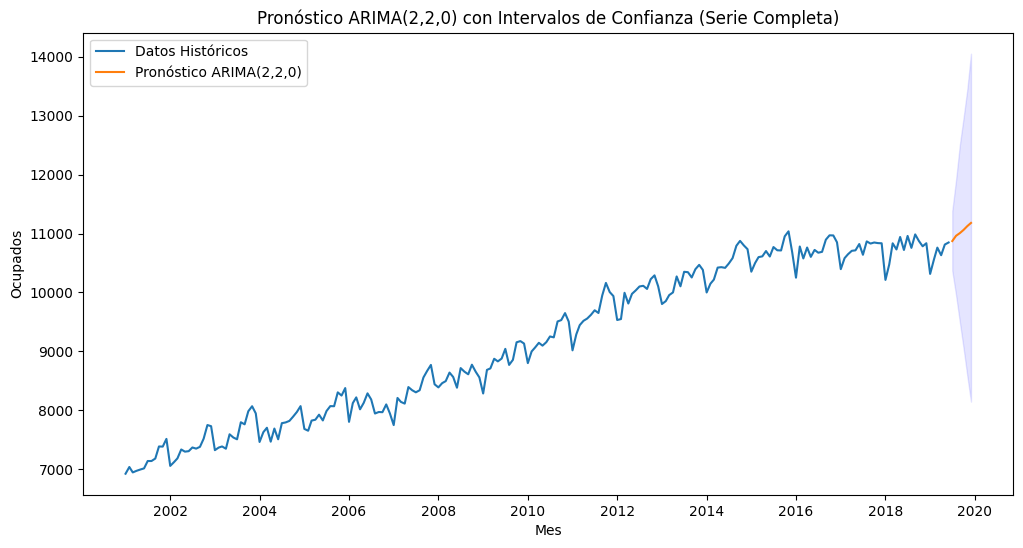

In [19]:
# Generate future index for the forecast plot
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=h, freq='MS')

fig = plt.figure(figsize=(12, 6))
plt.plot(data["Ocupados"],label="Datos Históricos") # Plot the full historical data
plt.plot(future_dates,preds['Point_forecast'],label="Pronóstico ARIMA(2,2,0)") # Updated label
plt.fill_between(future_dates,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.title("Pronóstico ARIMA(2,2,0) con Intervalos de Confianza (Serie Completa)") # Updated title
plt.xlabel("Mes")
plt.ylabel("Ocupados")
plt.show()

# **9. Validación de supuestos all data**

In [20]:
residuals_completo = modelo_final.resid()[1:] # 'residuals' es ahora el nuevo data sin el primer punto
signo = residuals_completo > residuals_completo.mean()
print("Primeros valores de los residuales sin el primer dato:")
print(residuals_completo.head())

Primeros valores de los residuales sin el primer dato:
mes
2001-02-01   -3336.401306
2001-03-01    -490.593227
2001-04-01    -152.113362
2001-05-01       2.515588
2001-06-01      39.827822
dtype: float64


## **Autocorrelación**

Prueba no paramétrica donde las hipótesis son las siguientes:

H0:ρ=0 (Es decir no hay autocorrelación)

H1:ρ≠0 (Es decir hay autocorrelación)

Rechazo H0 cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un α =0.05 ( α = nivel de significancia).

In [21]:
residuals = modelo_final.resid()[2:] # 'residuals' es ahora el nuevo data sin el primer punto
signo = residuals > residuals.mean()
print("Primeros valores de los residuales sin el primer dato:")
print(residuals.head())

Primeros valores de los residuales sin el primer dato:
mes
2001-03-01   -490.593227
2001-04-01   -152.113362
2001-05-01      2.515588
2001-06-01     39.827822
2001-07-01    101.287393
dtype: float64


In [22]:
runstest_1samp(signo, correction=False)

(np.float64(2.4555999121202783), np.float64(0.014064964886795846))

**Nota:**

El segundo valor corresponde al p-valor=0.014064964886795846, por lo tanto considerando un α=0.05, los resultados obtenidos  permiten rechazar la hipótesis nula, es decir, los residuos si tienen evidencia suficiente de correlación

In [23]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(residuals, lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,2.718875,0.099168,2.682133,0.10148


Con el resultado anterior no rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión Es probar por lo menos los primeros 20 rezagos.

In [24]:
# Realizar las pruebas de Ljung-Box y Box-Pierce
Resul_lb_bp_arima = sm.stats.acorr_ljungbox(residuals, lags=range(1,21), return_df=True, boxpierce=True)
Resul_lb_bp_arima["lb_ho"] = np.where(Resul_lb_bp_arima['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp_arima["bp_ho"] = np.where(Resul_lb_bp_arima['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

# Mostrar los resultados
Resul_lb_bp_arima

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,2.718875,9.916788e-02,2.682133,1.014797e-01,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,14.343795,7.678643e-04,14.097596,8.684524e-04,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,29.280668,1.955023e-06,28.698053,2.591640e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,29.329954,6.699020e-06,28.746006,8.803246e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,33.365762,3.183623e-06,32.654559,4.407015e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,33.663480,7.812487e-06,32.941549,1.076090e-05,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,38.988763,1.964145e-06,38.050942,2.963345e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,39.931600,3.299088e-06,38.951308,5.018686e-06,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,46.716299,4.432200e-07,45.399829,7.781018e-07,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,57.094547,1.279524e-08,55.217090,2.876460e-08,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


**Nota:**

Este análisis confirma y amplía lo que ya habíamos detectado con la prueba de rachas: sí existe autocorrelación significativa en los residuales de tu modelo ARIMA(2,2,0), específicamente a partir del rezago 2. Podría a futuro incluirse un modelo Sarima agregando un componente estacional

## **Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

H0: Comportamiento Homoscedastico (Es decir varianza constante)

H1: Comportamiento Heteroscedastico (Es decir varianza no constante)

In [25]:
#### **prueba de Ljung-Box**
sm.stats.acorr_ljungbox((residuals)**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,4.271177,3.876407e-02,4.213458,4.010449e-02
2,4.559224,1.023239e-01,4.496316,1.055936e-01
3,6.890751,7.546266e-02,6.775330,7.941419e-02
4,11.666767,2.000919e-02,11.422265,2.220662e-02
5,15.488937,8.465258e-03,15.123916,9.845779e-03
6,17.122804,8.842359e-03,16.698905,1.045590e-02
7,18.123959,1.142307e-02,17.659472,1.360460e-02
8,22.620426,3.887337e-03,21.953396,5.002936e-03
9,28.733069,7.187367e-04,27.763160,1.044757e-03
10,28.996744,1.247558e-03,28.012583,1.796894e-03


**Nota:**

Los resultados de la Tabla anterior, permiten rechazar la hipótesis nula de homoscedasticidad. Es decir que los residuales presenta hetoroscedasticidad. Por lo tanto,  existe comportamiento tipo ARCH o GARCH.

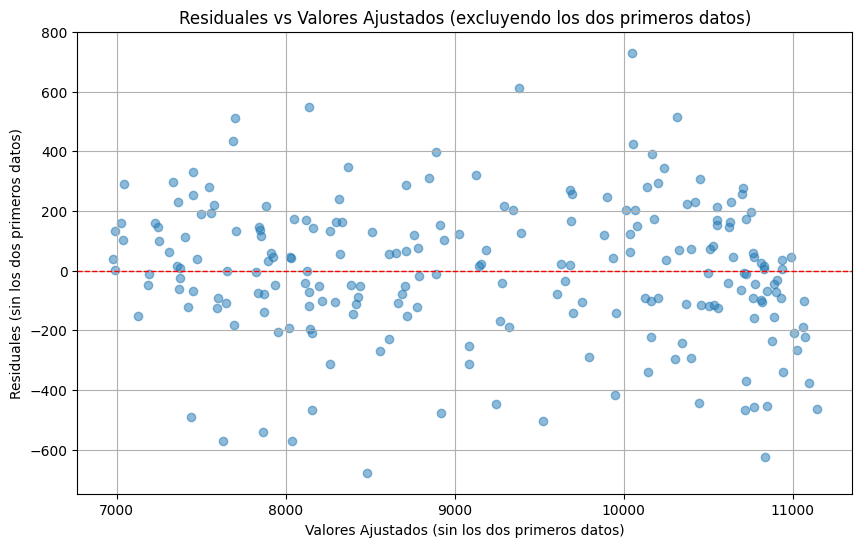

In [26]:
# Graficar residuales vs valores ajustados (excluyendo los dos primeros datos)
# ==============================================================================
plt.figure(figsize=(10, 6))
plt.scatter(modelo_final.fittedvalues()[2:], modelo_final.resid()[2:], alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Valores Ajustados (sin los dos primeros datos)")
plt.ylabel("Residuales (sin los dos primeros datos)")
plt.title("Residuales vs Valores Ajustados (excluyendo los dos primeros datos)")
plt.grid(True)
plt.show()

 Este gráfico respalda el diagnóstico de heteroscedasticidad

## **Normalidad**

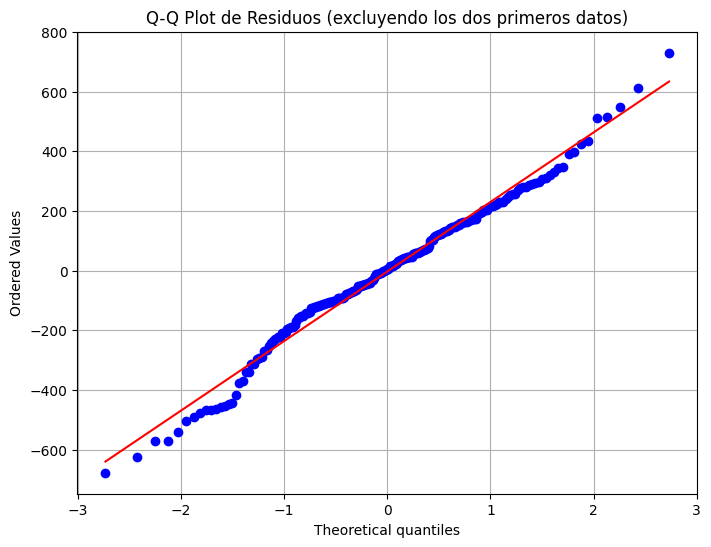

In [27]:
# Se normaliza los residuales para observar el grafico qqplot

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot de Residuos (excluyendo los dos primeros datos)')
plt.grid(True)
plt.show()

**Nota:**

El gráfico muestra un ajuste razonable a la línea, lo cual es consistente con los resultados de la prueba de Jarque-Bera que no permitieron rechazar la hipótesis de normalidad de los residuos para el modelo ARIMA(2,2,0).

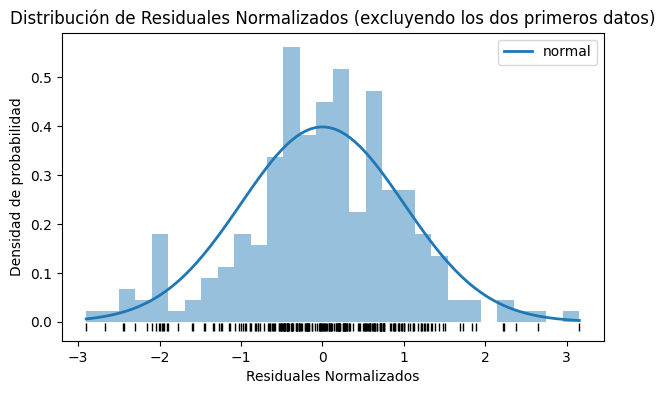

In [28]:
# Normalizar los residuales
normalized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)


mu, sigma = stats.norm.fit(normalized_residuals)
x_hat = np.linspace(min(normalized_residuals), max(normalized_residuals), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)


fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=normalized_residuals, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(normalized_residuals, np.full_like(normalized_residuals, -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución de Residuales Normalizados (excluyendo los dos primeros datos)')
ax.set_xlabel('Residuales Normalizados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend()
plt.show()

* **Nota:**

En el gráfico anterior se puede apreciar que la distribución presenta simetría, lo anterior podría reflejar normalidad en la distribución de los errores. Sin embargo, para confirmar esta sospecha, se procede a correr las pruebas de Jarque Bera y de Shapiro. En este caso, las pruebas de hipótesis de estas pruebas son las siguientes:

- H0: Los errores siguen una distribución normal
- H1: Los errores no siguen una distribución normal

In [29]:
stats.shapiro(residuals)

ShapiroResult(statistic=np.float64(0.9859687070594156), pvalue=np.float64(0.028707029289762567))

In [30]:
stats.jarque_bera(residuals)

SignificanceResult(statistic=np.float64(4.420794692075721), pvalue=np.float64(0.10965706805630777))

* **Nota:**

Según la prueba de Shapiro, se rechaza la hipótesis nula de que los errores siguen una distribución normal. Sin embargo, la prueba de Jarque Bera arroja que el p-valor (0.109) es mayor que 0.05 por lo que, no se rechaza la hipótesis nula de normalidad. 

De igual forma, la prueba de Shapiro es más potente para detectar la no-normalidad en muestras. La implicación es que, aunque visualmente los residuales se ajustan bastante bien a la curva,la prueba de Jarque Bera no fue concluyente y la prueba de Shapiro sugiere que hay suficiente evidencia estadística para decir que la suposición de normalidad de los residuales no se cumple para el modelo ARIMA(2,2,0).

Esto, junto con la heteroscedasticidad y la autocorrelación, indica que el modelo aún tiene oportunidades de mejora en la captura de toda la estructura de los datos adicionando posiblemente estacionaldiad.

# **10. Intervalos de confianza usando boostrap**

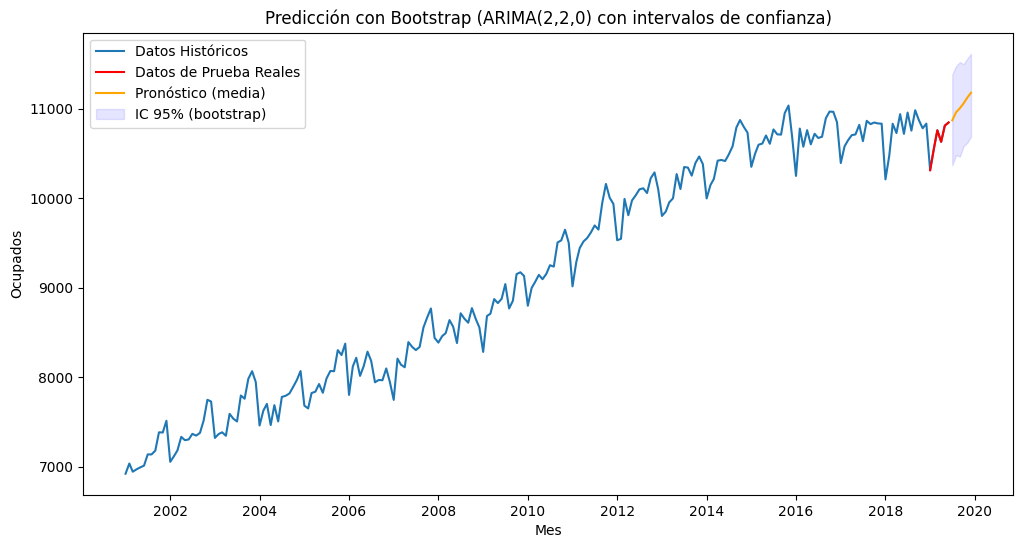

In [31]:
# Parámetros
h = 6
n_bootstrap = 1000

# Pronóstico futuro (del modelo ajustado a toda la serie)
# Usamos modelo_final (ARIMA(2,2,0) ajustado con todos los datos)
point_forecast = modelo_final.predict(n_periods=h, return_conf_int=False)
point_forecast = np.asarray(point_forecast).ravel()

# Residuos in-sample (del modelo_final)
# Aseguramos que se usen los residuales a partir del tercer punto, como hemos analizado
residuals = modelo_final.resid()[2:]

# Índice futuro usando la frecuencia real/inferida (usamos la última fecha de 'data')
last_date = data.index[-1]
future_index = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=h, freq='MS')

# --- Bootstrap: sumar residuos muestreados a la media pronosticada ---
sampled = np.random.choice(residuals, size=(n_bootstrap, h), replace=True)
bootstrap_forecasts = point_forecast + sampled  # broadcasting

lower_bound = np.percentile(bootstrap_forecasts, 2.5, axis=0)
upper_bound = np.percentile(bootstrap_forecasts, 97.5, axis=0)


pred_df = pd.DataFrame({
    "Point_forecast": np.asarray(point_forecast).ravel(),
    "lower_95": lower_bound,
    "upper_95": upper_bound
}, index=future_index)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data.index, data['Ocupados'].values, label="Datos Históricos") # y_full es data['Ocupados']
ax.plot(test_td.index, test_td['Ocupados'].values, label="Datos de Prueba Reales", color="red" ) # Ahora incluyendo los datos de prueba
ax.plot(future_index, point_forecast, label="Pronóstico (media)", color="orange")
ax.fill_between(future_index, lower_bound, upper_bound, color="blue", alpha=0.1, label="IC 95% (bootstrap)")
ax.set_title("Predicción con Bootstrap (ARIMA(2,2,0) con intervalos de confianza)")
ax.set_xlabel("Mes")
ax.set_ylabel("Ocupados")
ax.legend()
plt.show()

In [32]:
pred_df

,Point_forecast,lower_95,upper_95
2019-07-01,10872.130920,10368.447316,11385.332629
2019-08-01,10961.956116,10483.062853,11478.091241
2019-09-01,11007.289398,10466.945596,11523.424522
2019-10-01,11060.899231,10582.005968,11499.078146
2019-11-01,11126.219194,10621.638694,11562.474447
2019-12-01,11180.070886,10689.150399,11616.326139


In [33]:
arima_220_metrics = results_expanded_df_sorted[results_expanded_df_sorted['Order'].apply(lambda x: x == (2, 2, 0))]

if not arima_220_metrics.empty:
    rmse_220 = arima_220_metrics['RMSE'].values[0]
    mae_220 = arima_220_metrics['MAE'].values[0]
    print(f"RMSE del modelo ARIMA(2,2,0) en los datos de prueba: {rmse_220:.2f}")
    print(f"MAE del modelo ARIMA(2,2,0) en los datos de prueba: {mae_220:.2f}")
else:
    print("El modelo ARIMA(2,2,0) no se encontró en los resultados de la búsqueda ampliada.")

RMSE del modelo ARIMA(2,2,0) en los datos de prueba: 228.55
MAE del modelo ARIMA(2,2,0) en los datos de prueba: 181.00


# **11. Comparación de los modelos**

In [34]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="mul",seasonal="mul")
ets_result = ets_model.fit()

## Se obtienen los hiperparametros

print(f"Alpha (Nivel): {ets_result.alpha}")
print(f"Beta (Tendencia): {ets_result.beta}")
print(f"Gamma (Estacionalidad): {ets_result.gamma}")
print(f"Param names: {ets_result.param_names}")

## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data['Ocupados'],error="add",trend="mul",seasonal="mul")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.525353314736116,'smoothing_trend': 5.2535331473611604e-05,'smoothing_seasonal':4.74646685263884e-05})

print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

Alpha (Nivel): 0.5253403923132627
Beta (Tendencia): 5.253403923132627e-05
Gamma (Estacionalidad): 4.746596076867373e-05
Param names: ['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']
0.525353314736116
5.2535331473611604e-05
4.74646685263884e-05


In [35]:
# Generar pronósticos del modelo ETS para el horizonte de prueba (h)
ets_forecast = ets_result.predict(start=len(train_td), end=len(train_td) + h - 1)

# Calcular RMSE del modelo ETS
rmse_ets = sqrt(mean_squared_error(test_td['Ocupados'], ets_forecast))

# Calcular MAE del modelo ETS
mae_ets = mean_absolute_error(test_td['Ocupados'], ets_forecast)

print(f"RMSE para el modelo ETS: {rmse_ets:.2f}")
print(f"MAE para el modelo ETS: {mae_ets:.2f}")

RMSE para el modelo ETS: 59.42
MAE para el modelo ETS: 53.34


## **Predicciones ETS**

In [36]:
point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2019-07-01    10915.692986  10686.494838  11144.067169
2019-08-01    10904.066111  10651.886285  11134.263982
2019-09-01    10997.718019  10722.810232  11287.730630
2019-10-01    11140.584055  10849.341906  11452.379025
2019-11-01    11165.790190  10851.581584  11496.152653
2019-12-01    11070.066575  10716.092945  11413.027157


In [37]:
comparative_metrics = pd.DataFrame({
    'Modelo': ['ARIMA(1,1,1) (auto_arima)', 'ARIMA(2,2,0) (manual)', 'ETS'],
    'RMSE': [rmse_test, rmse_220, rmse_ets],
    'MAE': [mae_test, mae_220, mae_ets]
})

print("Tabla Comparativa de Métricas (RMSE y MAE) en Datos de Prueba:")
display(comparative_metrics.sort_values(by='RMSE').round(2))

Tabla Comparativa de Métricas (RMSE y MAE) en Datos de Prueba:


,Modelo,RMSE,MAE
2,ETS,59.42,53.34
1,"ARIMA(2,2,0) (manual)",228.55,181.00
0,"ARIMA(1,1,1) (auto_arima)",346.24,314.94


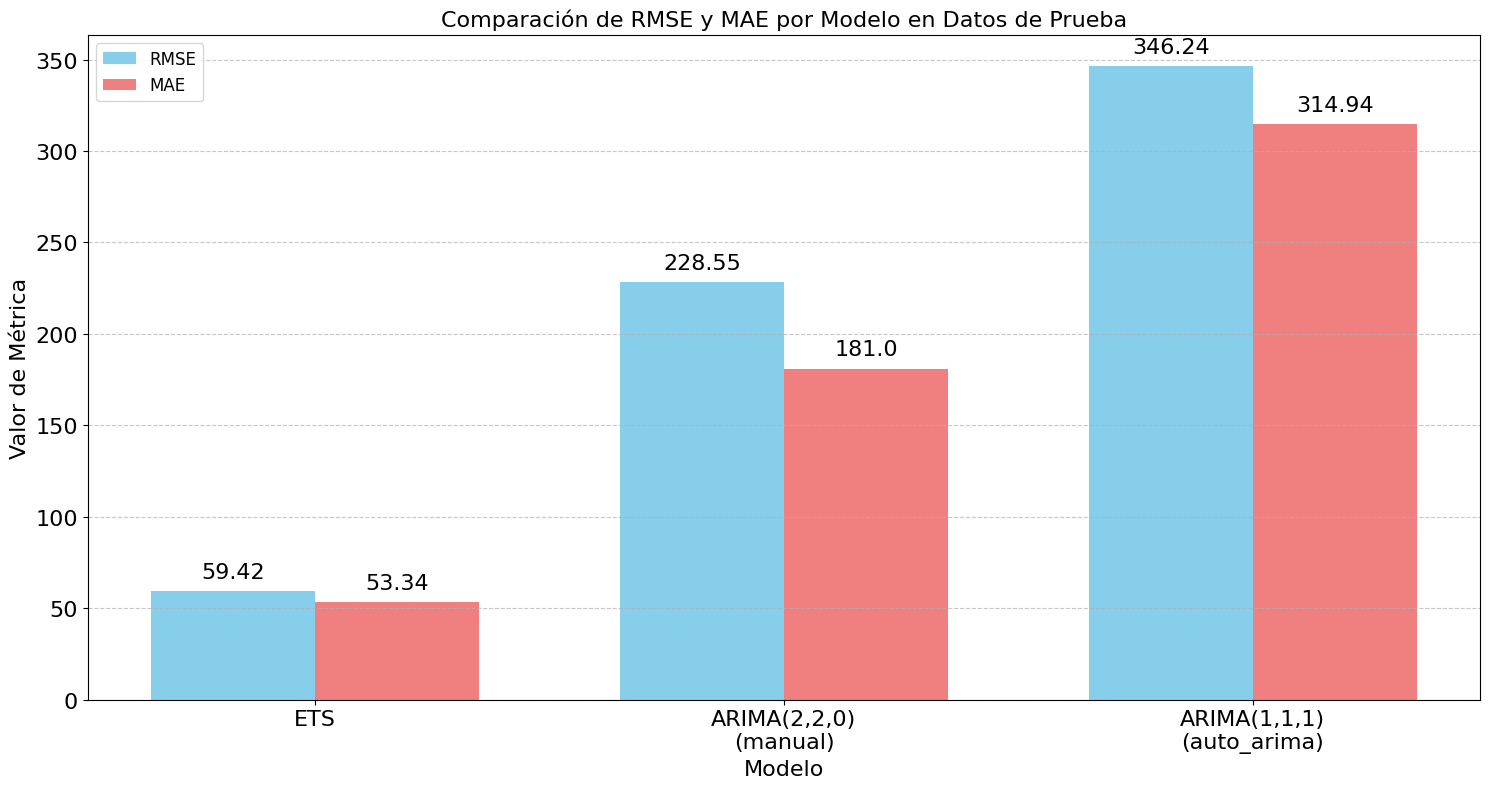

In [38]:
comparative_metrics = pd.DataFrame({
    'Modelo': ['ARIMA(1,1,1) (auto_arima)', 'ARIMA(2,2,0) (manual)', 'ETS'],
    'RMSE': [rmse_test, rmse_220, rmse_ets],
    'MAE': [mae_test, mae_220, mae_ets]
})

# Sort by RMSE for better visualization
comparative_metrics_sorted = comparative_metrics.sort_values(by='RMSE').round(2)

fig, ax = plt.subplots(figsize=(15, 8)) # Aumentar un poco la altura también

bar_width = 0.35
index = np.arange(len(comparative_metrics_sorted))

bar1 = ax.bar(index - bar_width/2, comparative_metrics_sorted['RMSE'], bar_width, label='RMSE', color='skyblue')
bar2 = ax.bar(index + bar_width/2, comparative_metrics_sorted['MAE'], bar_width, label='MAE', color='lightcoral')

ax.set_xlabel('Modelo', fontsize=16) # Aumentado
ax.set_ylabel('Valor de Métrica', fontsize=16) # Aumentado
ax.set_title('Comparación de RMSE y MAE por Modelo en Datos de Prueba', fontsize=16) # Aumentado
ax.set_xticks(index)

# Make labels horizontal and wrap them if they are too long
wrapped_labels = [textwrap.fill(label, 15) for label in comparative_metrics_sorted['Modelo']]
ax.set_xticklabels(wrapped_labels, rotation=0, ha='center', fontsize=16) # Aumentado
ax.tick_params(axis='y', labelsize=16) # Aumentado

ax.legend(fontsize=12) # Aumentado
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir los valores en la parte superior de las barras
def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        # Aumentar el tamaño de la fuente para los números encima de las barras
        ax.text(bar.get_x() + bar.get_width()/2, yval + 5, round(yval, 2), ha='center', va='bottom', fontsize=16) # Aumentado

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.show()

## **Conclusiones**

La tabla comparativa demuestra de manera contundente que, para esta serie de tiempo ('Ocupados') y el horizonte de pronóstico establecido, el ETS Model es el que ofrece la mayor precisión predictiva en los datos de prueba. Le sigue el ARIMA(2,2,0) manual, y finalmente el ARIMA(1,1,1) de auto_arima.

Este análisis resalta la importancia de comparar diferentes enfoques de modelado de series de tiempo y evaluar su rendimiento en un conjunto de datos de prueba para determinar el modelo más adecuado para la tarea de pronóstico.

Aunque auto_arima es una herramienta muy útil para la selección automática de modelos, su elección se basa a menudo en criterios de información (como AIC o BIC) que evalúan el ajuste del modelo a los datos de entrenamiento. Sin embargo, como demuestra este caso, un modelo manual puede tener un mejor rendimiento predictivo en el conjunto de prueba.

La no normalidad junto con la heteroscedasticidad y la autocorrelación, indica que el modelo aún tiene oportunidades de mejora en la captura de toda la estructura de los datos adicionando posiblemente estacionaldiad.